# Foxes vs Rabbits

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from westworld.environment import GridEnvironment
from westworld.agents import BaseAgent
from westworld.objects import BaseObstacle,BaseTrigger,BaseCollectible
from westworld.simulation import Simulation
from westworld.colors import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


##### Simple rabbits experiments
- Several rabbits who whill look for food and eat what they can find
- Wandering rabbits until they find food they can eat
- Rabbits who look for food and can die if they don't find in time, with collectibles re-appearing over time - param: search strategy
- Rabbits who reproduce over time and transmit their search strategy
- Rabbits can be sexier than others
- Rabbits can bear children for longer time for more fitness

##### Introducing foxes
- Adding foxes who can eat rabbit if they find some
- Adding fleeing behavior for rabbits

##### Complex behaviors
- Variable parameters
- Reinforcement Learning

##### Other ideas
- Varying maps with obstacles and quiet zones

# Experiment 1 - Rabbits quietly eating
Grid environments with several rabbits who whill look for food and eat what they can find

##### Defining food

In [3]:
class Food(BaseCollectible):
    def __init__(self,x,y):
        super().__init__(x,y,color = (220,150,50),img_asset = "ball")

##### Defining rabbits

In [4]:
class Rabbit(BaseAgent):
    
    def __init__(self,x,y,curiosity = 5):
        super().__init__(x,y,color = (229, 229, 229),curiosity = curiosity)
    
    def step(self):
        
        # Find closest food
        targets = self.find_closest(name = "Food",k = 1)
        
        # If there is still food, move towards the food
        if len(targets) > 0:
            
            target = targets[0]
            
            # Use naive pathfinding for faster computation as there is no obstacle
            self.move_towards(obj = target,naive = True)
            
        # Otherwise just wandering
        # Changing direction every n steps where n = curiosity
        else:
            self.wander()

##### Preparing environment and simulation

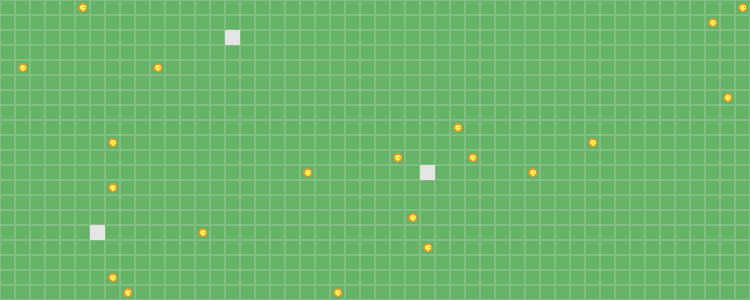

In [5]:
# Setup spawners
rabbit_spawner = lambda x,y : Rabbit(x,y,curiosity = 5)
food_spawner = lambda x,y : Food(x,y)

# Setup environment
env = GridEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(rabbit_spawner,3)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [6]:
# Setup simulation
sim = Simulation(env,fps = 10,name="RabbitsVsFoxesExperiment1")

In [7]:
sim.run_episode(n_steps = 100,save = False,replay = True)

  0%|          | 0/100 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=200), Output()), _dom_classes=('widget-…

IntSlider(value=0)

0

# Experiment 2 - Rabbits that have to explore and find food
In this second experiment rabbits don't have the perfect view of the environment, they have a vision range. They will explore and wander in the environment to find food. Once they found one, they move towards it to eat it. 

##### What do we need to add?
- Only finding food in a given range using the ``.find_in_range()`` function instead of ``.find_closest()``
- An attribute to store the next target (otherwise, at each step tick, the rabbit could randomly choose another food than the one it was directed to)
- A visualization of the vision range, with changing colors if the rabbit is looking for food, or if it has found at least one closeby

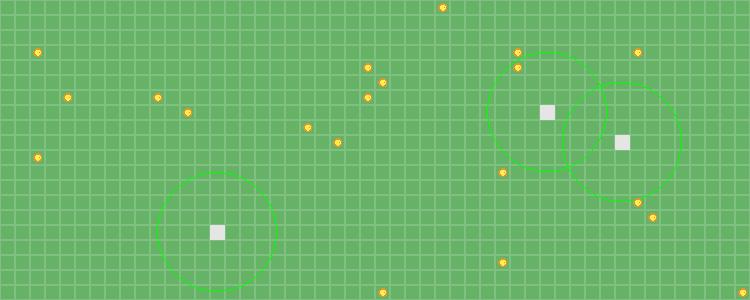

In [36]:
import random

class Rabbit(BaseAgent):
    
    def __init__(self,x,y,curiosity = 5,vision_range = 10,show_range = True):
        super().__init__(x,y,color = (229, 229, 229),curiosity = curiosity)
        self.vision_range = vision_range
        self.show_range = show_range
        self.range_color = GREEN
        
        # Store the food the rabbit was looking for
        self.next_target = None
        
    def postrender(self):
        if self.show_range:
            self.render_circle(radius = self.vision_range,color = self.range_color,thickness = 1)
    
    def step(self):
        
        # Find closest food
        targets = self.find_in_range(name = "Food",radius = self.vision_range)
        
        # If there is food around, move towards the food
        if len(targets) > 0:
            self.range_color = RED
            
            # Choose among targets in range
            # TODO could be optimized to go to the closest one
            # If the rabbit was already looking for a specific piece of food, we go fetch it
            # If the next piece of food is not in range anymore (another rabbit has eaten it), just take another one
            if self.next_target is None or self.next_target not in targets:
                target = random.choice(targets)
                self.next_target = target
            else:
                target = self.next_target
            
            # Use naive pathfinding for faster computation as there is no obstacle
            self.move_towards(obj = target,naive = True)
            
        # Otherwise just wandering
        # Changing direction every n steps where n = curiosity
        else:
            self.range_color = GREEN
            self.wander()
            
            
# Setup spawners
rabbit_spawner = lambda x,y : Rabbit(x,y,curiosity = 5,vision_range = 4)
food_spawner = lambda x,y : Food(x,y)

# Setup environment
env = GridEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(rabbit_spawner,3)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [37]:
# Setup simulation
sim = Simulation(env,fps = 100,name="RabbitsVsFoxesExperiment2")
sim.run_episode(n_steps = 200,save = False,replay = True)

  0%|          | 0/200 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=200, max=200), Output()), _dom_classes=…

IntSlider(value=0, max=200)

0

# Experiment 3 - Rabbits that can die if they don't find food in time
In this 3rd experiments rabbits have to find food before they starve to death. Concretely they have a hunger ticking clock. If it goes to 0, the rabbit dies. If they eat something they survive longer. <br>
Food grows randomly in the environment over time. 

##### What do we need to add?
- A hunger "life", visualized directly on the rabbit
- The behavior of removing the rabbit if it dies
- A collectible callback on the food collection to feed the rabbit
- A random regeneration of food if there are not enough

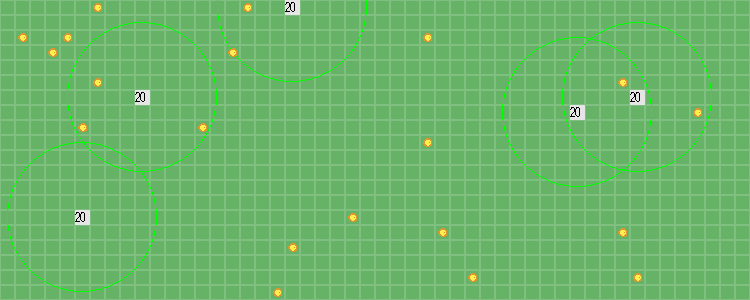

In [57]:
import random

class Food(BaseCollectible):
    def __init__(self,x,y,quantity = 5):
        super().__init__(x,y,color = (220,150,50),img_asset = "ball")
        self.quantity = quantity

    def on_trigger(self,obj):
        obj.life += self.quantity    
        

class Rabbit(BaseAgent):
    
    def __init__(self,x,y,curiosity = 5,vision_range = 10,show_range = True,hunger_resistance = 20):
        super().__init__(x,y,color = (229, 229, 229),curiosity = curiosity)
        self.vision_range = vision_range
        self.show_range = show_range
        self.range_color = GREEN
        
        # Store the food the rabbit was looking for
        self.next_target = None
        
        # Prepare life
        self.life = hunger_resistance
        
    def postrender(self):
        if self.show_range:
            self.render_circle(radius = self.vision_range,color = self.range_color,thickness = 1)
            
        self.render_text(self.life,size = 12,color=(0,0,0))
    
    def step(self):
        
        # Find closest food
        targets = self.find_in_range(name = "Food",radius = self.vision_range)
        
        # If there is food around, move towards the food
        if len(targets) > 0:
            self.range_color = RED
            
            # Choose among targets in range
            # TODO could be optimized to go to the closest one
            # If the rabbit was already looking for a specific piece of food, we go fetch it
            # If the next piece of food is not in range anymore (another rabbit has eaten it), just take another one
            if self.next_target is None or self.next_target not in targets:
                target = random.choice(targets)
                self.next_target = target
            else:
                target = self.next_target
            
            # Use naive pathfinding for faster computation as there is no obstacle
            self.move_towards(obj = target,naive = True)
            
        # Otherwise just wandering
        # Changing direction every n steps where n = curiosity
        else:
            self.range_color = GREEN
            self.wander()
            
        # After each step, the rabbit lose one life unit
        self.life -= 1
        
        # If the rabbit dies we remove it from the environment
        if self.life == 0:
            self.kill()
            
            
class CustomEnvironment(GridEnvironment):
    
    def post_step(self):
        
        if self.clock > 0 and self.clock % 5 == 0:
            self.spawn(food_spawner,4)
            
# Setup spawners
rabbit_spawner = lambda x,y : Rabbit(x,y,curiosity = 5,vision_range = 5)
food_spawner = lambda x,y : Food(x,y,quantity = 10)

# Setup environment
env = CustomEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(rabbit_spawner,5)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [58]:
# Setup simulation
sim = Simulation(env,fps = 100,name="RabbitsVsFoxesExperiment2")
sim.run_episode(n_steps = 200,save = False,replay = True)

  0%|          | 0/200 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=200, max=200), Output()), _dom_classes=…

IntSlider(value=0, max=200)

0